# Homework 1: Named Entity Recognition (NER) with Sequence Labeling Models
## CS4740/5740 Fall 2022

### Milestone Submission Due: **September 15, 2022 (11:59 PM)** 

### Project Submission Due: **September 27, 2022 (11:59 PM)**






**Names:** Fengyue(Lisa) Zhao, Jiaqi Liang

**Netids:** fz227, jl4274




**Editing your version of this notebook:** One partner should make a copy of this notebook and share it with your partner.  **However**, because of synchronization issues (even though Colab works with Google Drive), changes made in this notebook at the same time from different computers/browser windows may not save. We will go so far as to recommend that you close the tab with this notebook when you are not working on it so your partner doesn't face sync issues.


**Collaboration policy:** please be sure to check the collaboration policy on the [course website](https://courses.cs.cornell.edu/cs4740/2022fa/)!



> Assignment authors & testers: CS 4740/5740 professors and TAs from this and previous semesters, Chenxin Fang, Meghana Srivastava, Khonzoda Umarova, as well as Ruizhe Wang, Han Xia, and Heather Zhang.

# **Introduction**
---

In this project, you will tackle the **Named Entity Recognition** task: you'll implement models that identify named entities in text and tag them with the appropriate label. A primer on this task is provided further on.  We will treat this as a **sequence-tagging task**: for each token in the input text, assign one of the following 5 entity labels -- **ORG** (Organization), **PER** (Person), **LOC** (Location), **MISC** (Miscellaneous), and **O** (Not Named Entity) -- as well as a BIO-format prefix **B-** (token is the *beginning* of a named entity) or **I-** (token is *inside* a named entity). Overall, this yields 9 different labels: **B-ORG, I-ORG, B-PER, I-PER, B-LOC, I-LOC, B-MISC, I-MISC** and **O**.

For this project, you will implement two sequence labeling approaches:
- Model 1 : a Hidden Markov Model (HMM)
- Model 2 : a Maximum Entropy Markov Model (MEMM)/Logistic Regression classifier (also known as a MaxEnt classifier). Feature engineering is strongly suggested for this model!

A key component of both models is implementation of the Viterbi algorithm, which we will use to find the most likely tag sequence to assign to an input text.

## **Logistics**

---

- You are **strongly encouraged** to work in **groups of 2 students**. Students in the same group will get the same grade. Thus, you should make sure that everyone in your group contributes to the project. 
- **Do not form teams of two on Kaggle** (You *will* form teams on a different platform; details TBA) because submitting separately gives you more tries, which is useful when experimenting with different models.
- A part of your submission would involve uploading your notebook (details would be provided soon!). So, please enter all code and answer all the questions in this colab notebook.
- In this assignment you are asked to make two submissions:
  1. Intermediate **milestone submission due on 9/15/22 (11:59 PM)**. For this, please 1) have your teams formed (mechanism TBA) and  2) submit predictions of your first model (HMM) on Kaggle. This means that you should aim to complete Part 1 and Part 2 of the assignment by this milestone. Points will be awarded for meeting the milestone deadline, but we will only grade for completion, not correctness. 
  2. The **final homework submission due on 9/27/22 (11:59 PM)**. (details TBA)
- Please be sure to consult the [list](https://docs.google.com/document/d/1-QmpkZYJDCM4gQQ9sZW2EwD5ltYy1CFjlJTbhD0Be-A/edit?usp=sharing) of banned packages/libraries before you start implementing your models. Note that this list may get updated.



## **Advice**

---

1. Please read through the entire notebook before you start coding. That might inform your code structure.
2. An assignment outline and grading breakdown (subject to minor adjustments) is found below; please consult it.
3. The project is somewhat open ended. We will ask you to implement the models, but in some cases precise data structures and so on can be chosen by you. However, to integrate with Kaggle, you will need to submit Kaggle predictions using the given evaluation code (more instructions later).

<a name="outline"></a>
## **Assignment outline and grading breakdown**
- [Part 1](#part1)
  - [Q1](#q1) [10 pts]
- [Part 2](#part2)
  - [Unknown Word Handling](#unknowns_handling) [15 pts]
  - [HMM Implementation](#hmm_implementation) [20 pts]
  - [Viterbi Implementation](#viterbi_implementation) [20 pts]
  - [Validation](#validation_data) [3 pts]
  - [Q2.1](#q2.1) [5 pts]
  - [Q2.2](#q2.2) [5 pts]
  - [Q2.3](#q2.3) [5 pts]
  - [Q2.4](#q2.4) [5 pts]
- [Part 3](#part3)
  - [Features](#features) [35 pts]
  - [MEMM Implementation](#memm_implementation) [25 pts]
  - [Q3.1](#q3.1) [5 pts]
  - [Q3.2](#q3.2) [5 pts]
  - [Q3.3](#q3.3) [5 pts]
  - [Q3.4](#q3.4) [5 pts]
- [Part 4](#part4)
  - [Q4.1](#q4.1) [7 pts]
  - [Q4.2](#q4.2) [7 pts]
  - [Q4.3](#q4.3) [7 pts]
- [Part 5](#part5)
  - [Q5](#q5)


Meeting the milestone deadline [10 pts];

Outperforming our baseline on Kaggle [15 pts];



## **Named Entity Recognition: Review**

---

NER refers to the information extraction technique of identifying and categorizing key information about entities within textual data. NER is important for:
  - Detecting entities in search engines and voice assistants for more relavent search results.
  - Automatically parsing resumes.
  - ...and much more!

In our dataset named entity tags are formatted in BIO/IOB format. With this format, entity tags get a prefix. Prefix "B-" is added to the first word/token of the entity name. All following tokens that are part of the same entity name would get prefix "I-". 

Here is an example sentence: "ZIFA
said
Renate
Geotschel
of
Austria
won the women's World Cup  downhill race in Germany."
Entity "Renate Goetschl" gets "Renate" (B-PER) and "Goestchl" (I-PER). Similarly, for "World Cup" we'd have "World" (B-MISC) and "Cup" (I-MISC). If an entity only has one token, then its entity tag would still have prefix "B-". "O" is used to denote tokens that are not part of any named entity. Thus, from the example above, we'd have:

```"ZIFA" B-ORG```

 ```"said" O```

 ```"Renate" B-PER```

 ```"Goetschl" I-PER```

 ```"of" O```

 ```"Austria" B-LOC```

 ```"won" O```

 ```"the" O```

 ```"women's" O```

 ```"World" B-MISC```

 ```"Cup" I-MISC```

 ```"downhill" O```

 ```"race" O```

 ```"in" O```

 ```"Germany" B-LOC```


Although NER is predominantly handled by deep learning approaches, for now let's use HMMs and MEMMs. 


To read more on NER, we refer to any of the following sources:
1. Medium post [1](https://umagunturi789.medium.com/everything-you-need-to-know-about-named-entity-recognition-2a136f38c08f) and [2](https://medium.com/mysuperai/what-is-named-entity-recognition-ner-and-how-can-i-use-it-2b68cf6f545d).
2. Try out [this](https://demo.allennlp.org/named-entity-recognition/named-entity-recognition) AlllenNLP demo! Please note that this demo uses a slightly different format of NER tags.

## **Evaluation: Entity Level Mean F1**

---

The standard evaluation measures to report for NER are recall, precision, and F1 score
(also called F-measure) evaluated at the **named entity level** (not at the token level). The code for this has been provided later under the validation section under Part 2. Please use this code when evaluating your models. 


If P and T are the sets of predicted and true *named entity spans*, respectively, (e.g, the five named entity spans in the above example are "Zifa", "Renate Goetschl", "Austria", "World Cup", and "Germany") then

####<center>Precision = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{P}|}$ and Recall = $\frac{|\text{P}\;\cap\;\text{T}|}{|\text{T}|}$.</center><br/>


####<center>F1 = $\frac{2 * \text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$. </center><br/>

For each type of named entity, e.g. *LOC*ation, *MISC*ellaneous, *ORG*anization and *PER*son, we calculate the F1 score as shown above, and take the mean of all these F1 scores to get the **Entity Level Mean F1** score for the test set. If $N$ is the total number of labels (i.e., named entity types), then

####<center>Entity Level Mean F1 = $\frac{\sum_{i = 1}^{N} \text{F1}_{{label}_i}}{N}$. </center>

More details under the validation section in Part 2.



<a name="part1"></a>
# **Part 1: Dataset**
[[^^^]](#outline) 

Our data is a modified version of the WikiNEuRal ([ Tedeschi et al.](https://aclanthology.org/2021.findings-emnlp.215.pdf)) dataset.

Load the dataset as follows:
  1. Obtain the data from Data tab of the [Kaggle competition](https://www.kaggle.com/t/200697e4726f448986930dd4e823e957).
  2. Unzip the data. Put it into your Google Drive, run the cells below to mount it to Colab:


In [74]:

# !pip install geotext
# !pip install nltk


In [75]:
from collections import Counter
import nltk
from nltk import pos_tag
#nltk.download('averaged_perceptron_tagger')
from geotext import GeoText
import numpy as np
from collections import defaultdict

In [76]:
# from google.colab import drive
import os
# drive.mount('/content/drive', force_remount=True)

In [77]:
import json

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(),"cs-4740-fa22-hw1-named-entity-recognition")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'val.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

Here's a few things to note about the dataset above:
1. We have loaded 3 `.json` files: for training, validation, and testing.
2. The train and validation files contain the following 3 fields (each is a nested list): 
  - **'text'** - actual input tokens
  - **'NER'** - the token-level entity tag 
  - **'index'** - index of the token in the dataset
3. The test data only has **'text'**, and **'index'** fields. You will need to submit your prediction of the **'NER'** tag to Kaggle.


### **Q1: Initial Data Observations**

In the space below please add your code for dataset explorations for Q1.

In [78]:
## add your code here
print("The document length of training data is ", len(train['text']))
print("The document length of validation data is ", len(val['text']))
print("The document length of testing data is ", len(test['text']))


def tokenSize(corpus):
    if type(corpus) == list:
        return sum(tokenSize(subcorpus) for subcorpus in corpus)
    else:
        return 1

print("The dataset size of training data is ", tokenSize(train['text']))
print("The dataset size of validation data is ", tokenSize(val['text']))
print("The dataset size of testing data is ", tokenSize(test['text']))


The document length of training data is  7000
The document length of validation data is  400
The document length of testing data is  400
The dataset size of training data is  166394
The dataset size of validation data is  9344
The dataset size of testing data is  8864


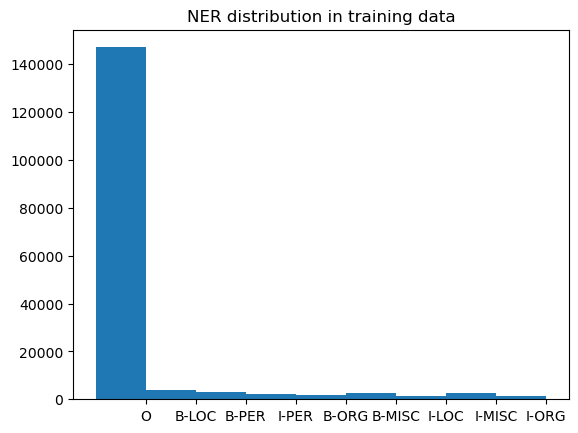

Counter({'B-LOC': 4060, 'B-PER': 3016, 'B-MISC': 2815, 'I-MISC': 2566, 'I-PER': 2217, 'B-ORG': 1725, 'I-LOC': 1451, 'I-ORG': 1431})


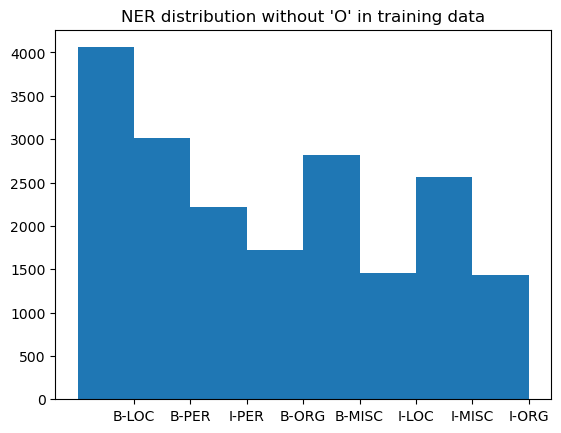

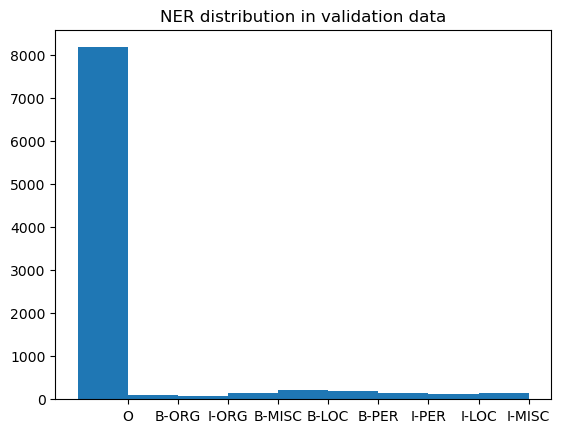

Counter({'B-LOC': 225, 'B-PER': 192, 'I-MISC': 156, 'I-PER': 153, 'B-MISC': 148, 'I-LOC': 111, 'B-ORG': 95, 'I-ORG': 87})


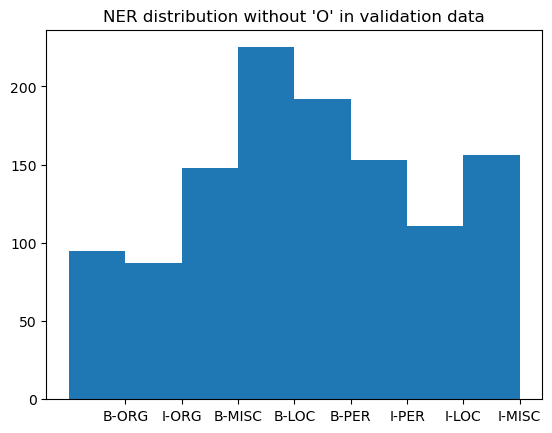

In [79]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

allNER = [item for subNER in train['NER'] for item in subNER]


NERs, counts = zip(*Counter(allNER).items())

indexes = np.arange(len(NERs))
width = 1

plt.bar(indexes, counts, width)
plt.xticks(indexes + width * 0.5, NERs)
plt.title('NER distribution in training data')
plt.show()


countNER = Counter(allNER)
del countNER['O']
print(countNER)
NERs, counts = zip(*countNER.items())

indexes = np.arange(len(NERs))
width = 1

plt.bar(indexes, counts, width)
plt.xticks(indexes + width * 0.5, NERs)
plt.title("NER distribution without 'O' in training data")
plt.show()



allNER = [item for subNER in val['NER'] for item in subNER]


NERs, counts = zip(*Counter(allNER).items())

indexes = np.arange(len(NERs))
width = 1

plt.bar(indexes, counts, width)
plt.xticks(indexes + width * 0.5, NERs)
plt.title('NER distribution in validation data')
plt.show()


countNER = Counter(allNER)
del countNER['O']
print(countNER)
NERs, counts = zip(*countNER.items())

indexes = np.arange(len(NERs))
width = 1

plt.bar(indexes, counts, width)
plt.xticks(indexes + width * 0.5, NERs)
plt.title("NER distribution without 'O' in validation data")
plt.show()

In [80]:
text_try = train['text'][1]
ner_try = train['NER'][1]
words=str()
for w in range(len(text_try)):
    if ner_try[w] == "O":
        words=words+str(text_try[w])+str(" ")
    else:
        words=words+str('[')+str(ner_try[w])+str(']')+str(text_try[w])

print(words)


Every aspect of life was regulated to some degree by the party , and the will of its founding-president , [B-PER]Mobutu[I-PER]Sese[I-PER]Seko. 


<a name="q1"></a>
[[^^^]](#outline) 

What are your initial observations after you explore the dataset?  Provide some quantitative data exploration. Assess dataset size, document lengths and the token-level NER class distribution, and the entity-level NER class distribution (skipping the 'O' label for the latter). Give some examples of sentences with their named entities bracketed, e.g. [[B-LOC Romania] state budget soars in June .] and [[B-ORG Zifa] said [B-PER Renate] [I-PER Goetschl] of [B-LOC Austria]...]. 


The size of training data is  7000 <br />
The size of validation data is  400<br />
The size of testing data is  400<br />
The dataset size of training data is  166394<br />
The dataset size of validation data is  9344<br />
The dataset size of testing data is  8864<br />

<br />

After plotting the histogram of token-level NER class, we found that the label 'O' is the most common label, unsurprisingly. So we ignored the 'O' label for now and looked at the entity-level NER class distribution for both the training data and validation data. We found that for both dataset, 'B-LOC' is the most common label and 'I-ORG'is the least common label. 


Here is one example of sentences: <br>
Every aspect of life was regulated to some degree by the party,and the will of its founding-president, [B-PER Mobutu]  [I-PER Sese]  [I-PER Seko].

<a name="part2"></a>
# **Part 2: Hidden Markov Model**
[[^^^]](#outline) 
---
In this part of the assignment, you will:
1. Implement code for counting and smoothing of labels and words, as well as unkown word handing, as necessary to support the Viterbi algorithm. 
2. Build a Hidden Markov Model in accordance with the provided function headers. **You may NOT change the function specifications.** Please ensure that your code is clear, concise, and, most important of all, modular. This means you should break your implementation down into smaller functions or write it within a class. Please compute all probabilities in natural log when building the HMM.
3. Implement the **Viterbi algorithm**, that can be used to infer token-level labels (identifying the appropriate named entity) for an input document. This process is commonly referred to as **decoding**. Bigram-based Viterbi is $ \mathcal{O}(sm^2)$ where *s* is the length of the sentence and *m* is the number of tags. Your implementation should have similar efficiency. The code for this can be used later on for the MEMM too.

### References
You may find chapters [3](https://web.stanford.edu/~jurafsky/slp3/3.pdf) and [8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) of Jurafsky and Martin book useful. In particular, section 3.4.1 covers ways to handle unknown words, and section 3.5 goes over smoothing. 

<a name="unknowns_handling"></a>
## **Unknown Word Handling**
[[^^^]](#outline) 
---

In [81]:
def unknown_word_handling(tokens, percent):
    #tokens = train['text']
    allTokens = [item for subitem in tokens for item in subitem]
    TOKENs, TOKENcounts = zip(*Counter(allTokens).items())
    TOKENs = list(TOKENs)
    TOKENcounts = list(TOKENcounts)
    dict_tokens = dict(zip(TOKENs, TOKENcounts))
    dict_tokens = sorted(dict_tokens.items(), key = lambda item:item[1])
    #print(sorted(dict_tokens.items(), key = lambda item:item[1]))
    percentage = int(len(TOKENs)*percent)
    dict_tokens_new= dict_tokens[0:percentage]
    #print(dict_tokens_new)
    unks=[]
    for item in dict_tokens_new:
        unks.append(item[0])
    #print(unks)

    for i in range(len(tokens)):
        for j in range(len(tokens[i])):
            if tokens[i][j] in unks:
                tokens[i][j] = '<unk>'

    train_text_new = tokens
    return train_text_new




In [82]:
train_text_new = unknown_word_handling(train['text'],0.1)
len([token for sentence in train_text_new for token in sentence if token =='<unk>'])



2482

<a name="hmm_implementation"></a>
## **HMM Implementation**
[[^^^]](#outline) 
---

In the skeleton code below, we have broken down the HMM into its three components: the transition matrix, the emission matrix, and the start state probabilities. We suggest you implement them separately and then use them to build the HMM.


In [83]:
# Returns the transition probabilities.
def build_transition_matrix(labels, k=0):
    
    """
    Returns a dictionary that has tuples of every label bigram as keys, and
    the associated value being the respective transition probabilities (in 
    natural log).

    Eg. {("O", "B-ORG"): -9.98690147425591, 
         ("B-LOC", "I-LOC"): -3.69537214,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
    
    #get types and counts of NERs
    allNER = [item for subNER in labels for item in subNER]
    from collections import Counter
    NERs, NERcounts = zip(*Counter(allNER).items())
    #get different sequences of NERs
    ner=list(NERs)
    ner.append('[end]')
    ner_count=list(NERcounts)
    seq=[]
    N=[]
    for n in range(0,len(ner)-1):
        for i in range(0,len(ner)):
            label=(ner[n],ner[i])
            seq.append(label)
            N.append(ner_count[n])

    #count of each sequence 
    count=[]
    for comb in seq:
        sentence_count=0
        if list(comb)[1] == '[end]': 
            for entity in labels:
                if entity[-1] == list(comb)[0]:
                    sentence_count=sentence_count+1
            count.append(sentence_count)
        else:
            for entity in labels:
                for i in range(len(entity)-1):
                    if list(comb) == entity[i:i+2]:
                        sentence_count=sentence_count+1
            count.append(sentence_count) 

    #calculate probabilities
    prob_trans = []
    for a in range(0,len(seq)):
    #smoothing here add k
        problog=np.log((count[a]+k)/(N[a]+k*(len(ner))))
        prob_trans.append(problog)
    #output dictionary
    transition = {}
    for b in range(0,len(seq)):
        key=seq[b]
        transition[key]=prob_trans[b]
  
    return(transition)


In [84]:
#build_transition_matrix(labels=train['NER'],k=0)

In [85]:
# Returns the emission probabilities.
def build_emission_matrix(tokens, labels, k=0):
    """
    Returns a dictionary that has label-token tuples as keys, and emission 
    probabilities (in natural log) for each respective label-token pair as values.  

    Eg. {("O", "Because"): -10.133904545421267, 
         ("I-PER", "Markov"): -7.428569227340841,
         ...,
         ...,
        }
    
    :parameter tokens: A list where each element represents a sentence, 
    and each sentence is a list of its tokens. (Eg. [['The', 'most', 
    'significant', 'damage', 'was', 'on', 'Tortola', '.'], [...], ...])
    :type tokens: List[List[String]]
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
    emission = defaultdict(float)
    allNERs = [item for subitem in labels for item in subitem]
    uni_NERs = list(set(allNERs))
    allTokens = [item for subitem in tokens for item in subitem]
    uni_tokens = list(set(allTokens))
    V = len(uni_tokens)
    #print(len(allNERs)==len(allTokens)) # work
    numNER = dict(Counter(allNERs).items())
    
    count = defaultdict(int)
    for i in range(len(tokens)):
        for j in range(len(tokens[i])):
            entry = (labels[i][j],tokens[i][j])
            count[entry] = count[entry] + 1
    
    #print(count) # work
    
    for token in uni_tokens:
        for ner in uni_NERs:
            entry = (ner, token)
            #print(entry)
            if entry in count.keys():
                #print('yes!!')
                prob = np.log((count[entry] + k)/(numNER[ner]+k*V))
            else:
                #print('smoothing!!')
                prob = np.log(k/(numNER[ner]+k*V))
            emission[entry] = prob
            
    emission[('[end]','<end>')] = np.log(1)

    
    return emission


In [86]:
# build_emission_matrix([['the','most'],['damage','on','earth']], [['a','b'],['c','a','b']], k=1)


defaultdict(float,
            {('a', 'earth'): -1.9459101490553135,
             ('c', 'earth'): -1.791759469228055,
             ('b', 'earth'): -1.252762968495368,
             ('a', 'the'): -1.252762968495368,
             ('c', 'the'): -1.791759469228055,
             ('b', 'the'): -1.9459101490553135,
             ('a', 'most'): -1.9459101490553135,
             ('c', 'most'): -1.791759469228055,
             ('b', 'most'): -1.252762968495368,
             ('a', 'on'): -1.252762968495368,
             ('c', 'on'): -1.791759469228055,
             ('b', 'on'): -1.9459101490553135,
             ('a', 'damage'): -1.9459101490553135,
             ('c', 'damage'): -1.0986122886681098,
             ('b', 'damage'): -1.9459101490553135,
             ('[end]', '<end>'): 0.0})

In [87]:
#build_emission_matrix(train['text'], train['NER'], k=0)

In [88]:
# Returns the starting state probabilities.
def get_start_state_probs(labels, k=0):
    """
    Returns a dictionary that has labels for keys, and each respective state 
    probabilities (in natural log) for values.  

    Eg. {"O": -10.133904545421267, 
         "I-PER": -7.428569227340841,
         ...,
         ...,
        }
    
    :parameter labels: A list where each element represents a sentence, 
    and each sentence is a list of NER labels for each of its tokens. (Eg. 
    [['O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O'], [...], ...])
    :type labels: List[List[String]]
    :parameter k: an optional parameter for smoothing
    :type k: int
    """
    from collections import defaultdict
    allNER = [item for subNER in labels for item in subNER]
    NERs = list(set(allNER))
    start_Prob = dict.fromkeys(NERs, 0.0)
    count = defaultdict(int)
    
    for e in labels:
        startNER = e[0]
        count[startNER] = count[startNER] + 1
        
    for startNER in NERs:
        if startNER in count.keys():
            start_Prob[startNER] = np.log((count[startNER]+k)/(len(labels)+k*len(NERs)))
        else:
            start_Prob[startNER] = np.log(k/(len(labels)+k*len(NERs)))
        #start_Prob[startNER] = count[startNER]/len(labels)
        
    start_Prob['[end]'] = -99999999999999999999
    
    return start_Prob


In [89]:
# Takes in the tokens & labels and returns a representation of the HMM.
# Call the three functions above in this function to build your HMM.
def build_hmm(tokens, labels):
    start_Prob = get_start_state_probs(labels,k=0.01)
    transition = build_transition_matrix(labels, k=0.02)
    emission = build_emission_matrix(tokens, labels,k=0.03)
    allTokens = list(set([item for subitem in tokens for item in subitem]))
    allLabels = list(set([item for subitem in labels for item in subitem]))
    allLabels.append('[end]')
    return (allLabels, allTokens, start_Prob, transition, emission)


<a name="viterbi_implementation"></a>
## **Viterbi Implementation**
[[^^^]](#outline) 
---

At the end of your implementation, we expect a function or class that maps a sequence of tokens (observation) to a sequence of labels via the Viterbi algorithm.

In [90]:
# Takes in the HMM build above and an observation (i.e. a list of tokens),
# and returns a list with predicted named entity mappings for the tokens.
# The returned list should be the same length as the input obeservation.
def viterbi(hmm, observation):
    #print(observation)
    allNERs, allTokens, start_Prob, transition, emission = hmm
    #print(allNERs)
    allNERs_noEnd = [NER for NER in allNERs if NER != '[end]']
    L = len(observation) # length of the observation list
    #print("L:",L)
    numNER = len(allNERs)
    
    for i in range(L):
        if observation[i] not in allTokens:
            observation[i] = "<unk>"
        
    
    observation.append('<end>')
    L = len(observation)
    #print(observation)
    
    table = {NER: [[0.0,[]] for col in range(L)] for NER in allNERs}
    #print(table)
    
    for NER in allNERs:
        #print("NER",NER)
        prob = start_Prob[NER] + emission[(NER,observation[0])]
        table[NER][0][0] = prob
    #print(table)
    
    for col in range(1,L): #for each token
        #print(col)
        for NER1 in allNERs: #for each NER1 row
            choices = []
            for NER2 in allNERs_noEnd: # for each possible previous NER2
                #print(NER1, NER2)
                pre = table[NER2][col-1]
                #print('pre:', pre)
                prob = pre[0] + emission[(NER1,observation[col])] + transition[(NER2,NER1)]
                #print(prob)
                tags = pre[1]+[NER2]
                #print('tags:',tags)
                choice = (prob,tags)
                choices.append(choice)
                #print('choices:', choices)
            target = max(choices)
            #print("target:",target)
            table[NER1][col] = target
            #print("table22222:",table)

    #print("table",table)
    
    max_prob = -999999999999999999
    max_tags = None
    
    for NER in allNERs:
        prob,tags = table[NER][-1]
        if prob > max_prob:
            max_prob = prob
            max_tags = tags
    
    return max_tags
                

In [91]:
tokens = [['3', '2' ,'3'],['3','1'],['1','3'],['1','1'],['3','1','3']]
labels = [['H', 'C','H'],['H','C'],['C','H'],['C','C'], ['H','C','H']]
hmm = build_hmm(tokens, labels)

viterbi(hmm,['3','1','3','1'])

['H', 'C', 'H', 'C']

# HMM training

In [226]:

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(),"cs-4740-fa22-hw1-named-entity-recognition")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'val.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

In [93]:
#train_text_lowered = lowerCase(train['text'])
#train_text = unknown_word_handling(train_text_lowered,0.2)
train_text = unknown_word_handling(train['text'],0.15)



In [94]:
hmm = build_hmm(train_text,train['NER'])



In [95]:
# Here's a sample observations that you can use to test your code
obs_1 = ['Cornell',
 'University',
 'is',
 'located',
 'in',
 'Ithaca',
 'and',
 'was',
 'founded',
 "by", "Ezra", "Cornell", "." ]

# Uncomment and fill out the following line to test your implementation:
viterbi(hmm, obs_1)




['B-ORG',
 'I-ORG',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'O']

## **Validation Step**
<a name="validation_data"></a>
[[^^^]](#outline) 
---

In this part of the project, we expect you to train your HMM model (i.e., get transition and emission probabilities) on the labeled training data and evaluate it on the validation data. Report **Entity Level Mean F1**, which was explained earlier. Please use the code we have provided below to compute this metric.

Please also take a look into your misclassified cases, as we will be performing error analysis in the *Evaluation* section. We expect smoothing, unknown word handling and correct emission (i.e., lexical generation) probabilities.

Consider the example below. After getting a sequence of NER labels for the sequence of tokens from your Viterbi algorithm implementation, you need to convert the sequence of tokens, associated token indices and NER labels into a format which can be used to calculate **Entity Level Mean F1**. We do this by finding the starting and ending indices of the spans representing each entity (as given in the corpus) and adding it to a list that is associated with the label with which the spans are labelled. To score your validation data on Google Colab or your local device, you can get a dictionary format as shown in the picture below from the function **format_output_labels** of both the predicted and true label sequences, and use the two dictionaries as input to the **mean_f1** function.

NOTE: We do **not** include the spans of the tokens labelled as "O" in the formatted dictionary output.

In [96]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (LOC, ORG, MISC or PER) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    Eg. if [token_labels] = ["B-ORG", "I-ORG", "O", "O", "B-ORG"]
           [token_indices] = [15, 16, 17, 18, 19]
        then dictionary returned is 
        {'LOC': [], 'MISC': [], 'ORG': [(15, 16), (19, 19)], 'PER': []}

    :parameter token_labels: A list of token labels (eg. B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, B-MISC, OR I-MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"LOC":[], "MISC":[], "ORG":[], "PER":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
        curr_label = label.split('-')[-1]
        if label.startswith('B-') or curr_label != prev_label:
            if prev_label != 'O':
                label_dict[prev_label].append((start, token_indices[idx-1]))
            if curr_label != 'O':
                start = token_indices[idx]
            else:
                start = None
      
        prev_label = curr_label

    if start is not None and prev_label != 'O':
        label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict


In [97]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    """ 
    Calculates the entity-level mean F1 score given the actual/true and 
    predicted span labels.
    :parameter y_pred_dict: A dictionary containing predicted labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_pred_dict: Dict<key [String] : value List[Tuple]>
    :parameter y_true_dict: A dictionary containing true labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_true_dict: Dict<key [String] : value List[Tuple]>

    Implementation modified from original by author @shonenkov at
    https://www.kaggle.com/shonenkov/competition-metrics.
    """
    F1_lst = []
    valid_dict={}
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        valid_dict[key] = [num_correct,num_true,num_pred]
        F1_lst.append(F1)
    #print(valid_dict)
    return np.mean(F1_lst),valid_dict



In [104]:
# Evaluate/validate your model here

F1 = []
summ = {"LOC":[0,0,0], "MISC":[0,0,0], "ORG":[0,0,0], "PER":[0,0,0]}
for i in range(len(val['text'])):
    obs = val['text'][i]
    true_token_labels = val['NER'][i]
    token_indices = val['index'][i]
    pred_token_labels = viterbi(hmm, obs)
    y_pred_dict = format_output_labels(pred_token_labels, token_indices)
    #print("y_pred_dict is : " + str(y_pred_dict))
    y_true_dict = format_output_labels(true_token_labels, token_indices)
    #print("y_true_dict is : " + str(y_true_dict))
    #print(mean_f1(y_pred_dict, y_true_dict))
    f1 = mean_f1(y_pred_dict, y_true_dict)[0]
    dic = mean_f1(y_pred_dict,y_true_dict)[1]
    #print(dic)
    for key in summ:
        if key in dic.keys():
            for i in range(0,3):
                summ[key][i] = dic[key][i] + summ[key][i]
    #print(summ)
    F1.append(f1)

meanF1 = np.mean(F1)
print(summ)
print("Entity document Mean F1 score is : ", meanF1)



{'LOC': [118, 225, 141], 'MISC': [60, 165, 88], 'ORG': [35, 95, 55], 'PER': [108, 192, 117]}
Entity document Mean F1 score is :  0.5058374542124542


In [99]:

result = {"LOC":{"Recall":[],"Precision":[],"F1":[]}, "MISC":{"Recall":[],"Precision":[],"F1":[]}, "ORG":{"Recall":[],"Precision":[],"F1":[]}, "PER":{"Recall":[],"Precision":[],"F1":[]}}
for key in summ.keys():
    result[key]['Recall'] = summ[key][0]/summ[key][1]
    result[key]['Precision'] = summ[key][0]/summ[key][2]
    result[key]['F1'] = (2*result[key]['Recall']*result[key]['Precision'])/(result[key]['Recall']+result[key]['Precision'])
print(result)


{'LOC': {'Recall': 0.5244444444444445, 'Precision': 0.8368794326241135, 'F1': 0.6448087431693991}, 'MISC': {'Recall': 0.36363636363636365, 'Precision': 0.6818181818181818, 'F1': 0.4743083003952569}, 'ORG': {'Recall': 0.3684210526315789, 'Precision': 0.6363636363636364, 'F1': 0.4666666666666667}, 'PER': {'Recall': 0.5625, 'Precision': 0.9230769230769231, 'F1': 0.6990291262135923}}


<a name="q2.1"></a>
[[^^^]](#outline) 
## **Q2.1: Explain your HMM Implementations**

Explain how you implemented the HMM including the Viterbi algorithm. Make clear which parts were implemented from scratch vs. obtained via an existing package (review the Logistics section for information on packages that are not allowed). Explain and motivate any design choices providing the intuition behind them.


#### **A2.1:**

The first part is unknown word handling. In our algorithm, we choose the second alternative listed in Jurafsky and Martin's book. The main idea is to replace the words in training data with <unk> based on their frequency. Since the frequency distribution is skewed, we didn't replace words whose frequency is smaller than a certain value. Most of the words have 1 or 2 frequencies, but some common words like "the" and "a" and large frequencies. Using certain values to replace words with <unk> will make us lose a lot of informative words. Thus, we choose to replace words based on quantiles like the last 20%. The function is named `unknown_word_handling(tokens,percent)`. The input has two parameters, one is the original document text and the other is the quantile. <br>
    
Then we start to build three main parts of the Viterbi algorithm. <br>
    
The first part is generating the transition matrix. The function is named `build_transition_matrix(labels, k)` . The transition probability is the probability of one tag depending on the given previous tag, which is ``P(tag1|tag2)``. Also, to specify the end state, we choose to append a [end] tag at the end of the sentence. Since some of the tag combinations will have 0 occurrences and the logarithm for 0 doesn't exist, we try to smooth this probability by adding a specific value k.<br>
    
The second part is generating the emission matrix. The function is named `build_emission_matrix(tokens, labels, k)`. The emission probability is the probability of one word depending on a given tag, which is `P(word|tag)`. We also include a <end> word in the word lists to specify the end state and include k to smooth the 0 probabilities. Since there is a (<end>,[end]) combination, we assigned log(1) to this probability and it will not affect the result. <br>
The third part is generating the start state. The function is named `get_start_state_probs(labels, k)`. We need to get q0 in the Viterbi chart. The start probability is the probability of each tag appearing at the beginning of a sentence. <br>
    
In the function `build_hmm(tokens, labels)`, we input the training labels and tokens, as well as call the three functions above to return the matrices that are needed by the Viterbi algorithm. Also, in this function, we can specify different smoothing parameters k. The output is the unzipped label list, token list, start probabilities, transition matrix, and emission matrix. <br>
    
After that, we input all of the above to build a Viterbi algorithm called viterbi(hmm, observation). The parameter observation is the actual test/validation data and hmm is the inputs from the build_hmm() function. We initialized a table to store all probabilities and states recorded in each step. Also, we use the same logic as above the deal with unknown words that appear in the test data. The start state is the start probabilities times the first words’ emission probabilities. In the loops, each iteration we compare the probabilities of previous step times emission and transition probabilities. Then, we create a list ` choice` to record each step’s best choice tags and the maximized probabilities. 


<a name="q2.2"></a>
[[^^^]](#outline) 
## **Q2.2: Results Analysis**

Explain here how you evaluated the models. Summarize the performance of your system and any variations that you experimented with on the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis.


#### **A2.2:**

We evaluated the models using the F1 score calculated by the provided function. The entity document Mean F1 score on the validation data is 0.5058. We experimented with different parameters on unknown word handling (below which frequency we change the word into <unk>), transition/start probability smoothing parameters, and emission smoothing parameters. We did not record all the experiment results, but below is a table for some experiment we have done and how do they influence the performance of HMM model.

| unknown word handling percentage | smoothing (transition/start) | smoothing (emission) | F1 |
| --- | --- | --- | ---|
| 0 | 0 | 0  | 0
| 0.1 | 1 | 1 | 0.23 |
| 0.15 | 1 | 1 | 0.25 |
| 0.15 | 0.1 | 0.1 | 0.46 |
| 0.15 | 0.02 | 0.03 | 0.50 |
    
We observe that the best parameters of the smoothing are very small (smaller than 0.1). We chose 1 as the parameter for smoothing in the first try and this did not work. We guess it is because there are many words with only 1 occurance in the trainning data, if we add 1 for the smoothing reason, the model cannot tell the probablistic differences between smoothing and actual word in the data.
  

<a name="q2.3"></a>
[[^^^]](#outline) 
## **Q2.3: Error Analysis**
When did the system work well? When did it fail?  Any ideas as to why? How might you improve the system?


In [100]:
import pandas as pd 

pd.DataFrame.from_dict(result)

,LOC,MISC,ORG,PER
Recall,0.524444,0.363636,0.368421,0.562500
Precision,0.836879,0.681818,0.636364,0.923077
F1,0.644809,0.474308,0.466667,0.699029


#### **A2.3:**

The overall F1 score of HMM model with respect to the validation data is 0.5058. According the previous table, we can see different tags have different recall, precision and F1 scores. The recall is #Correct NEs / # Predicted NEs, the precision is #Correct NEs / #NEs in answer key, and the F-Measure(F1) is 2PR / (P+R). In our model, this table shows that the PER tags have the best performance, with the highest F1 score of 0.699, the recall of 0.563, the precision of 0.923. According to the definition of recall, we can say there are about 56.3% trure PER tags are correctly detected by the HMM model. The LOC has relatively good performance, and MISC is a bit worse. The ORG tags have the worst performance, with the lowest F1 score of 0.466, the recall of 0.368 and the precision of 0.636. The result depicted that this system works well when recognizing person's names and locations, but it fails when recognizing organization names and miscellaneous entities. <br> 

This probably is because persons' names and locations' names have some simpler rules to follow, like first name plus last name, or location name plus city or town. However, the organization names and miscellaneous entities may have more complex rules, some of them may contain non-informative words like"the","of","a" inside these names. Also, this probably is because persons' names and locations' names have less words, maybe one or two, but organization can have long combination of words, which are difficult to detect.

<a name="q2.4"></a>
[[^^^]](#outline) 
## **Q2.4: What is the effect of unknown word handling and smoothing?**

#### **A2.4:**

The effect of unknown word handling is to avoid the situation that the observation string cannot be captured by our hmm model because it does not occur in our training data. Our unknown word handling implementation is choosing a certain percentage of frequency level n and then changing all the words with frequency lower than n into <unk>. If we encounter unknown word in our observation, we replace it with <unk>.
    
Training data cannot fully reflect the real world. The effect of smoothing is to make sure all NER sequences (in transition probability) and all NER-word pair (in emission probability) can occur with some probability, so that even though we do not see certain sequence or pair in the trainning data, they still have some possibility of occuring in the observation.
    

<a name="part3"></a>
# **Part 3: Maximum Entropy Markov Model** 
[[^^^]](#outline) 
---

In this section, you will implement a Maximum Entropy Markov Model (**MEMM**) to perform the same NER task. Your model should consist of a MaxEnt classifier with Viterbi decoding. 

1. We have already performed tokenizations for documents. You can either use a MaxEnt classifier from an existing package or write the MaxEnt code yourself. **Important note:  MaxEnt classifiers are statistically equivalent to multi-class logistic regression, so you can use packages for multi-class LR instead of MaxEnt.**

2. Use the classifier to learn a probability $P(t_i|features)$. You may replace either the lexical generation probability – $P(w_i|t_i)$ – or the transition probability – $P(t_i|t_{i−1})$ – in the HMM with it, or you may replace the entire *lexical generation probability * transition probability*  calculation – $P (w_i|t_i) ∗ P (t_i|t_{i−1)} – $ in the HMM with it. 

3. To train such a classifier, you need to pick some feature set. The content of the feature set is up to you, but try different ones, and evaluate your choices on the validation set. Pick the feature set that performs overall the best according to the F1 measure. If you draw inspiration for your features from external sources, please link them in the code.
  * While there are many directions to take when looking for features, you may start by exploring parts of speech that appear in sentences. There are several libraries (ex. [nltk](https://www.nltk.org/book/ch05.html)) that process sentences and identify parts of speech. If you end up using a library to extract parts of speech tags or other features, please indicate this in your asnwer to Q3.1.

4. Use your own implementation of the **Viterbi algorithm**, which you can modify from the one you developed for the HMM model. You will need the probabilities that you obtain from the MaxEnt classifier. 

5. Remember to use same training and validation split when evaluating the MEMM to have a **fair comparison** with your **HMM model**.


Please also take a look into your misclassified cases, as we will be performing error analysis in Part 4. 





---
Here's a summary of the workflow for Part 3:

![alt text](https://drive.google.com/uc?export=view&id=14VfjW3yDyXLojWM_u0LeJYdDOSLkElBn)




Note that we have not provided any skeleton code for how you should do feature engineering since this is meant to be an open ended task and we want you to experiment with the dataset. However, please remember to make sure that you code is concise, clean, and readable! Ultimately, we expect a function or class  mapping a sequence of tokens to a sequence of labels. At the end of this section you should have done the following:
1. Extract Features
2. Build & Train MaxEnt
3. Call Viterbi when evaluating

### References
You may find [chapter 8](https://web.stanford.edu/~jurafsky/slp3/8.pdf) of Jurafsky and Martin book useful. In particular, you could consider section 8.5.2 for features in NER. 

<a name="features"></a>
## **Feature Engineering**
[[^^^]](#outline) 
---

In [44]:
# a function that look at the data in details to help us choose feature
def look_data(tokens, ners, i):
    output = []
    for j in range(len(tokens[i])):
        label = ners[i][j]
        if label != 'O':
            a = tokens[i][j] + '(' + label + ')'
        if label == 'O':
            a = tokens[i][j]
        output.append(a)
    print(' '.join(output))

In [235]:
for i in range(5090,5091):
    look_data(train['text'], train['NER'], i)

In July 2017 , she was appointed to be the next President of the Supreme(B-ORG) Court(I-ORG) , succeeding Lord Neuberger(B-PER) of Abbotsbury(B-LOC) .


In [46]:

def feature_extract(tokens,labels =None): 
    from nltk import pos_tag
    output = []
    keys =  ['text',
             #'pre_text',
             #'next_text',
             'pos_is_NNP',
             "any_cap", 
             "all_cap", 
             #"contain_digit", 
             #"contain_dot", 
             "sentence_initial", 
             #"sentence_final",
             "is_loc",
             'is_nationality',
             "pre_B-LOC", "pre_B-PER", "pre_B-MISC", "pre_B-ORG", 'pre_O',
             "pre_I-LOC", "pre_I-PER", "pre_I-MISC", "pre_I-ORG",
             #"cur_University", 'cur_War', "cur_League",
             "pre_the",'pre_by',
             'pre_to', 'pre_from', 'pre_of', 'pre_at', 'pre_in','pre_on', 'pre_"','pre_as',
             "next_University", 'next_War', "next_League"]
    
    pre_labels = ["B-LOC", "B-PER", "B-MISC", "B-ORG", 'O'
                  , "I-LOC", "I-PER", "I-MISC", "I-ORG"]
    pre_words = ['the', 'by'
                 , 'to', 'from', 'of', 'at', 'in','on', '"', 'as']
    next_words = ['University', 'War','League']
    #current_words = ['University', 'War','League']
    
    for i in range(len(tokens)):
        sentence = tokens[i]
        from geotext import GeoText
        

        
        pos_l = pos_tag(sentence)
        for j in range(len(sentence)):
            token = sentence[j]
            
            places = GeoText(token)

            feature_vec = dict.fromkeys(keys, 0)
            feature_vec['text'] = token
            feature_vec['pos_is_NNP']  = int(pos_l[j][1] == 'NNP')
            feature_vec['all_cap'] = int(token.isupper())
            feature_vec['any_cap'] = int(any(map(str.isupper, token))) - feature_vec['all_cap']
            feature_vec['sentence_initial'] = int(j == 0)
            feature_vec['is_loc'] = int(((token in places.cities) or (token in places.countries)) and token != 'University')
            feature_vec['is_nationality'] = int(token in places.nationalities)

            # feature_vec['cur_University']  = int(token == 'University')
            # feature_vec['cur_War']  = int(token == 'War')
            # feature_vec['cur_League']  = int(token == 'League')
                    
            if (len(sentence) > 1) & (j != len(sentence)-1):
                next_word = sentence[j+1]
                #feature_vec['next_text'] = next_word
                if next_word in next_words:
                    feature = "next_" + next_word
                    #print(feature)
                    feature_vec[feature] = 1
                    
            if j > 0:
                pre_NER = labels[i][j-1]
                pre_word = sentence[j-1]

            
                #feature_vec['pre_text'] = pre_word
                
                if pre_NER in pre_labels:
                    feature = "pre_" + pre_NER
                    feature_vec[feature] = 1
                
                if pre_word.lower()  in pre_words:
                    feature = "pre_" + pre_word.lower() 
                    feature_vec[feature] = 1

            
            label = labels[i][j]
            entry = (feature_vec, label)
            output.append(entry)
            
    
    return output


In [48]:
# Your implementation here
def test_feature_extract(token, pos, pre_label=None, pre_word = None, next_word=None):

    from nltk import pos_tag
    from geotext import GeoText
    
    output = []
    keys =  ['text',
             #'pre_text',
             #'next_text',
             'pos_is_NNP',
             "any_cap", 
             "all_cap", 
             #"contain_digit", 
             #"contain_dot", 
             "sentence_initial", 
             #"sentence_final",
             "is_loc",
             'is_nationality',
             "pre_B-LOC", "pre_B-PER", "pre_B-MISC", "pre_B-ORG", 'pre_O',
             "pre_I-LOC", "pre_I-PER", "pre_I-MISC", "pre_I-ORG",
             #"cur_University", 'cur_War', "cur_League",
             "pre_the",'pre_by',
             'pre_to', 'pre_from', 'pre_of', 'pre_at', 'pre_in','pre_on', 'pre_"','pre_as',
             "next_University", 'next_War', "next_League"]
    
    pre_labels = ["B-LOC", "B-PER", "B-MISC", "B-ORG", 'O'
                  , "I-LOC", "I-PER", "I-MISC", "I-ORG"]
    pre_words = ['the', 'by'
                 , 'to', 'from', 'of', 'at', 'in','on', '"', 'as']
    next_words = ['University', 'War','League']
    #current_words = ['University', 'War','League']
    
    
    
    places  = GeoText(token)
    feature_vec = dict.fromkeys(keys, 0)
    feature_vec['text'] = token
    feature_vec['pos_is_NNP']  = int(pos == 'NNP')
    feature_vec['all_cap'] = int(token.isupper())
    feature_vec['any_cap'] = int(any(map(str.isupper, token))) - feature_vec['all_cap']
    feature_vec['is_loc'] = int((token in places.cities) or (token in places.countries))
    feature_vec['is_nationality'] = int(token in places.nationalities)

    # feature_vec['cur_University']  = int(token == 'University')
    # feature_vec['cur_War']  = int(token == 'War')
    # feature_vec['cur_League']  = int(token == 'League')
    
    # If token is in the begining of the sentence 
    if pre_label==None:
        feature_vec["sentence_initial"] = 1

    else:

        #feature_vec['pre_text'] = pre_word

        if pre_label in pre_labels:
            feature = "pre_" + pre_label
            feature_vec[feature] = 1
        
        if pre_word.lower() in pre_words:
            feature = "pre_" + pre_word.lower() 
            feature_vec[feature] = 1

    #feature_vec['next_text'] = next_word
    if next_word in next_words:
        feature = "next_" + next_word
        feature_vec[feature] = 1
        

        
    return feature_vec



In [51]:

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(),"cs-4740-fa22-hw1-named-entity-recognition")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'val.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())

In [54]:
def build_ME(tokens, labels, max_iter):
    
    train_text_unk = unknown_word_handling(tokens,0.2)
    
    allTokens = list(set([item for subitem in train_text_unk for item in subitem]))
    allLabels = list(set([item for subitem in labels for item in subitem]))
    
    train_feature = feature_extract(train_text_unk, labels)
    from nltk.classify import maxent
    encoding = maxent.TypedMaxentFeatureEncoding.train(train_feature)
    classifier = maxent.MaxentClassifier.train(train_feature, max_iter=max_iter)
    
    return classifier, allTokens, allLabels
    
    


<a name="memm_implementation"></a>
## **MEMM Implementation**
[[^^^]](#outline) 
---

In [57]:
ME = build_ME(train['text'], train['NER'], max_iter=100)



  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -2.19722        0.884
             2          -0.22478        0.884
             3          -0.21897        0.884
             4          -0.21201        0.884
             5          -0.20419        0.884
             6          -0.19595        0.884
             7          -0.18767        0.884
             8          -0.17960        0.887
             9          -0.17192        0.892
            10          -0.16471        0.898
            11          -0.15801        0.907
            12          -0.15181        0.912
            13          -0.14611        0.915
            14          -0.14085        0.924
            15          -0.13602        0.928
            16          -0.13158        0.934
            17          -0.12749        0.939
            18          -0.12372        0.943
            19          -0.12024        0.952
 

In [152]:
import pickle
f = open('ME.pickle', 'wb')
pickle.dump(classifier, f)
f.close()

In [184]:
# Takes in the classifier build above and an observation (i.e. a list of tokens),
# and returns a list with predicted named entity mappings for the tokens.
# The returned list should be the same length as the input obeservation.
 
        
def MEMM(ME, observation):
    classifier, allTokens, allNERs = ME
    uni_tokens = list(set(allTokens))
    L = len(observation) # length of the observation list
    #print("L:",L)
    numNER = len(allNERs)
    observation.append('<end>')
    pos_l = pos_tag(observation)
    #print(pos_l)
    
    for i in range(L):
        if observation[i] not in allTokens:
            observation[i] = "<unk>"

    
    L = len(observation)
    
    table = {NER: [[0.0,[]] for col in range(L)] for NER in allNERs}
    #print(table)
    
    # First token: start probability
    first_token = observation[0]
    
    if L>1:
        next_token = observation[1]
    else:
        next_token = None
    
    
    first_feature = test_feature_extract(first_token, pos=pos_l[0][1], next_word=next_token)
    start_probs = classifier.prob_classify(first_feature)
#     print("Feature analysis for ", first_token)
#     classifier.explain(first_feature)
    
    for NER in allNERs:
        #print("NER",NER)
        prob = start_probs.prob(NER)
        table[NER][0][0] = np.log(prob)
    #print(table)
   

    #Iteration for the rest of the observation
    
    for col in range(1,L): #for each token
        #print('O:',observation[col])
        for NER1 in allNERs: #for each NER1 row
            choices = []
            for NER2 in allNERs: # for each possible previous NER2
                #print(NER1, NER2)
                pre = table[NER2][col-1]
                #print('pre:', pre)
                token = observation[col]
                #print(pos_l[col][1])
                pos = pos_l[col][1]
                pre_label = NER2
                pre_word = observation[col-1]
                if col != L-1:
                    next_word = observation[col+1]
                else: next_word = None
                
                feature = test_feature_extract(token, pos=pos, pre_label=pre_label, pre_word = pre_word, next_word=next_word)
                classify_probs = classifier.prob_classify(feature)
                prob_ner = classify_probs.prob(NER1)
#                 print("Feature analysis for ", token, "with pre_NER = ", NER2)
#                 classifier.explain(feature)
                
                if prob_ner == 0:
                    prob_ner == 0.000000000000000000001
            
                prob = pre[0] + np.log(prob_ner)
                
                #print(prob)
                tags = pre[1]+[NER2]
                #print('tags:',tags)
                
                choice = (prob,tags)
                choices.append(choice)
                #print('choices:', choices)
            target = max(choices)
            #print("target:",target)
            table[NER1][col] = target
            #print("table22222:",table)

    #print("table",table)
    
    max_prob = -999999999999999999
    max_tags = None
    
    for NER in allNERs:
        prob,tags = table[NER][-1]
        if prob > max_prob:
            max_prob = prob
            max_tags = tags
    
    return max_tags
    

In [185]:
classifier, allTokens, allLabels = ME
#classifier.show_most_informative_features(n=2000, show="all")
#classifier.weights


In [186]:
# import pickle
# f = open('ME.pickle', 'rb')
# classifier2 = pickle.load(f)
# f.close()

In [227]:
# Here's a sample observations that you can use to test your code
obs = ['Cornell',
 'University',
 'is',
 'located',
 'in',
 'Ithaca',
 'and',
 'was',
 'founded',
 "by", "Ezra", "Cornell", "." ]

MEMM(ME, obs)



['B-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'O']

### **Validation**
---
In this section we want you to run your MaxEnt model on the validation dataset you extracted earlier. We want you to play around with different combinations of features in order to find which features work the best for your implementation. You will be asked to write about this process in detail in written question 3.3 so please spend time experimenting with features! Once again, please use the code we provided for computing Entity Level Avg F1 earlier when validating your model.

In [60]:
# Run your model on validation set
# You will need to 
# 1. Call your function above to get a prediction result on Validation Set
# 2. Report Metrics
# (See if you need to modify your feature set)

In [ ]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    """ 
    Calculates the entity-level mean F1 score given the actual/true and 
    predicted span labels.
    :parameter y_pred_dict: A dictionary containing predicted labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_pred_dict: Dict<key [String] : value List[Tuple]>
    :parameter y_true_dict: A dictionary containing true labels as keys and the 
                            list of associated span labels as the corresponding
                            values.
    :type y_true_dict: Dict<key [String] : value List[Tuple]>

    Implementation modified from original by author @shonenkov at
    https://www.kaggle.com/shonenkov/competition-metrics.
    """
    F1_lst = []
    valid_dict={}
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        valid_dict[key] = [num_correct,num_true,num_pred]
        F1_lst.append(F1)
    #print(valid_dict)
    return np.mean(F1_lst),valid_dict



In [61]:
# Evaluate/validate your model here

F1 = []
summ2 = {"LOC":[0,0,0], "MISC":[0,0,0], "ORG":[0,0,0], "PER":[0,0,0]}
for i in range(len(val['text'])):
    obs = val['text'][i]
    true_token_labels = val['NER'][i]
    token_indices = val['index'][i]
    pred_token_labels = MEMM(ME, obs)
    y_pred_dict = format_output_labels(pred_token_labels, token_indices)
    #print("y_pred_dict is : " + str(y_pred_dict))
    y_true_dict = format_output_labels(true_token_labels, token_indices)
    #print("y_true_dict is : " + str(y_true_dict))
    #print(mean_f1(y_pred_dict, y_true_dict))
    f1 = mean_f1(y_pred_dict, y_true_dict)[0]
    dic = mean_f1(y_pred_dict,y_true_dict)[1]
    #print(dic)
    for key in summ2:
        if key in dic.keys():
            for i in range(0,3):
                summ2[key][i] = dic[key][i] + summ2[key][i]
    #print(summ)
    F1.append(f1)

meanF1 = np.mean(F1)
print("Entity document Mean F1 score is : ", meanF1)




Entity document Mean F1 score is :  0.5060831088845795


In [101]:

result2 = {"LOC":{"Recall":[],"Precision":[],"F1":[]}, "MISC":{"Recall":[],"Precision":[],"F1":[]}, "ORG":{"Recall":[],"Precision":[],"F1":[]}, "PER":{"Recall":[],"Precision":[],"F1":[]}}
for key in summ2.keys():
    result2[key]['Recall'] = summ2[key][0]/summ2[key][1]
    result2[key]['Precision'] = summ2[key][0]/summ2[key][2]
    result2[key]['F1'] = (2*result2[key]['Recall']*result2[key]['Precision'])/(result2[key]['Recall']+result2[key]['Precision'])
#print(result2)


{'LOC': {'Recall': 0.5422222222222223, 'Precision': 0.8591549295774648, 'F1': 0.6648501362397821}, 'MISC': {'Recall': 0.3515151515151515, 'Precision': 0.7945205479452054, 'F1': 0.48739495798319327}, 'ORG': {'Recall': 0.35789473684210527, 'Precision': 0.8292682926829268, 'F1': 0.4999999999999999}, 'PER': {'Recall': 0.5572916666666666, 'Precision': 0.9224137931034483, 'F1': 0.6948051948051949}}


In [169]:
pd.DataFrame.from_dict(result2)

,LOC,MISC,ORG,PER
Recall,0.542222,0.351515,0.357895,0.557292
Precision,0.859155,0.794521,0.829268,0.922414
F1,0.664850,0.487395,0.500000,0.694805


<a name="q3.1"></a>
[[^^^]](#outline) 

## **Q3.1: Implementation Details**
Explain how you implemented the MEMM and whether/how you modified Viterbi (e.g. which algorithms/data structures you used, what features are included). Make clear which parts were implemented from scratch vs. obtained via an existing package.


#### **A3.1:**

1. We first decided what features should we choose for MEMM. By looking at data closely, we decided to use the following feature list:
             ['text'，
             'pos_is_NNP',
             "any_cap", 
             "all_cap",
             "sentence_initial", 
             "is_loc",
             'is_nationality',
             "pre_B-LOC", "pre_B-PER", "pre_B-MISC", "pre_B-ORG", 'pre_O',
             "pre_I-LOC", "pre_I-PER", "pre_I-MISC", "pre_I-ORG",
             "pre_the",'pre_by',
             'pre_to', 'pre_from', 'pre_of', 'pre_at', 'pre_in','pre_on', 'pre_"','pre_as',
             "next_University", 'next_War', "next_League"]
             
2. Then we started to implement two feature extractions, one for training data and one for observation. In the feature extraction process, we use nltk pos_tag and geotext GeoText for the features ['pos_is_NNP'], ["is_loc"], and ['is_nationality']. 

    2.1 feature extractions for training data: The output data structure is a list of tuples with the first element be the feature dictionary and the second element be the NER label. We looped through every word in every sentence in the data. And then first check for features about the word itself, like captalization, pos_is_NNP, is_loc, etc. Then check if the word is sentence initial, if not, we check the previous word and the NER of previous word. Then if the sentence length > 1 and the current word is not the last element in the sentence, we check the next word of it to see if it is in the next_word list which includes 'University', 'War', 'League', 'Mountains'.

     2.2 feature extractions for testing data: The output data structure is a feature dictionary. Unlike the training feature extraction, it takes more input: the current single word, its part-of-speech, the NER of previous word, the previous word, and the next word. The MEMM viterbi will produce those inputs to be used in this function. Then the function maps all the input into the feature dictionary.


3. Build the ME model: we first do the unknown-word-handling. And then use 2.1 to extract training feature data. Then we obtained an exsiting package -- nltk.classify.maxent -- to train our maxent classifier. Then we return the classifier, all tokens, and all NERs.


4. MEMM implementation: We modified viterbi from last HMM section. Since we do not have start probability anymore, we initialize the table by calling the test_feature_extract on the first element and then use the classifier from ME model to generate the probability distribution for each NER label. Then we have three loops, 1. iterate the observation from the second word to the end; 2. iterate all NER for each row; 3. iterate all NER again for each possible previous NER. Then we check all inputs for test_feature_extract and then extract feature for every word. Then the ME classifier was used to calculated the probability distribution for each NER label. We use the probability distribution to update the table. So instead of log(emission) + log(transition) in HMM, we only have one single log(ME_probability) in MEMM. The rest of the MEMM viterbi is similiar to HMM viterbi.




<a name="q3.2"></a>
[[^^^]](#outline) 

## **Q3.2: Results Analysis**
Explain here how you evaluated the MEMM model. Summarize the performance of your system and any variations that you experimented with the validation datasets. Put the results into clearly labeled tables or diagrams and include your observations and analysis.


#### **A3.2:**

We evaluated the MEMM models using the F1 score calculated by provided functions. The entity document Mean F1 score on the validation data is 0.5061. We experimented with different feature sets and iteration number. We did not record all the experiment results, but below is an approximate process of experimenting the feature sets and the iteration number. 

| Features | iteration | Accuracy | time(min) |
| --- | --- | --- | ---|
| all_cap, any_cup, sent_init | 10 | 0.0004  | ~10
| + current token, POS | 20 | 0.23 | ~60 |
| + pre_NER(binary)| 20 | 0.30 | ~70 |
| + is_Loc, is_nationality, pre_word(binary), next_word(binary)| 20 | 0.35 | ~70 |
| + is_Loc, is_nationality, pre_word(binary), next_word(binary)| 300 | 0.40 | ~900 |
| + is_Loc, is_nationality, pre_word(binary), next_word(binary)| 100 | 0.50 | ~300 |

We first just had simple features about the word itself with binary values, like capitalization. After 10 times of iteration, the accuracy was very low. Therefore, we keep adding more informative features. An interesting thing we observed was that sometimes adding more features lowered the accuracy. We thought this was because the added features were not informative enough and even disrupted the learning process of the model. Another thing we observed was that with increasing iteration number to a very big number actually worsened the model performance. We thought this was because overfitting. The model was too closely aligned to the training data and performed poorly in test data.


<a name="q3.3"></a>
[[^^^]](#outline) 

## **Q3.3: Feature Engineering**
What features are considered most important by your MaxEnt Classifier? Why do you think these features make sense? Describe your experiments with feature sets. An analysis on feature selection for the MEMM is required – e.g. what features **help most**, why? An **error analysis** is required – e.g. what sorts of errors occurred, why?

#### **A3.3:**

We have three kinds of features: (i) feature about the current token, like captalization, part-of-speech, if-it-is-location, etc; (ii) the label of previous token: pre_B-Loc, pre_O, etc; (iii) if the previous and next words are worth-noting: pre_the, pre_by, etc. The list of word is chosen by looking at the training data. For example we found that the named entities are more likely to occur after certain preposition/determiners, and different preposition may help us differentiate entity, such as that "by" is more likely to be followed by a person than a location. In general, the token itself plays the most important role in our MaxEnt Classifier according to the classifier.show_most_informative_features function. 

However, different tokens and different context have different ranks on features. One example is provided below: This is the feature explanation for classifying "Yale" in sentence "Yale University is a university. "
     
         Feature                                            B-ORG       O   B-PER   I-ORG
      --------------------------------------------------------------------------------
      next_University==1 (1)                             3.193
      pre_O==0 (1)                                      -2.826
      text=='Yale' (1)                                   2.684
      any_cap==1 (1)                                     0.908
      sentence_initial==1 (1)                            0.855
      pos_is_NNP==1 (1)                                  0.801
      pre_the==0 (1)                                    -0.599
    

  
And the most important feature to choose the right lable B-ORG is next_University==1.

However, the word "Cornell" in sentence "Cornell University in located in Ithaca" was assigned the incorrect label "B-PER". 

        Feature                                          B-PER      O   B-ORG    I-ORG
      --------------------------------------------------------------------------------
      text=='Cornell' (1)                                3.407
      pre_O==0 (1)                                      -1.834
      sentence_initial==1 (1)                            0.884
      any_cap==1 (1)                                     0.829
      pos_is_NNP==1 (1)                                  0.790



In this case, the most importatn feature is different -- it is the text=='Cornell' feature. Since Cornell can be a person name or a university name, it is ambiguous. It seems like the pre_O==0 feature prevented the classifier to choose "B_ORG" to be the lable.


In [107]:
import pandas as pd 

pd.DataFrame.from_dict(result2)

,LOC,MISC,ORG,PER
Recall,0.542222,0.351515,0.357895,0.557292
Precision,0.859155,0.794521,0.829268,0.922414
F1,0.664850,0.487395,0.500000,0.694805


The overall F1 score of MEMM is 0.5060. According the previous table, we can see different types of tags have different recall, precision and F1 scores. 

The recall is #Correct NEs / # Predicted NEs, the precision is #Correct NEs / #NEs in answer key, and the F-Measure(F1) is 2PR / (P+R). In our model, this table shows that the PER tags have the best performance, with the highest F1 score of 0.695, the recall of 0.557, the precision of 0.922. According to the definition of recall, there are about 55.7% of the true PER tags are correctly recognized. The LOC tag recognition have relatively good performance. Then is the performance of recognizing ORG tags. The MISC tags have the worst performance, with the lowest F1 score of 0.487, the recall of 0.351 and the precision of 0.794. The result depicted that this system works better when recognizing person's names and locations, but it fails when recognizing organization names and miscellaneous entities. This is very similar to the HMM result. In the MEMM model, these relatively large errors happens in MISC and ORG tags probably also because these entities have more complicated rules than PER and LOC tags. Also, it is probably because we didn't choose appropriate features targeting at these types of tags. 


In [193]:
# classifier.explain(test_feature_extract('Yale', 'NNP', next_word = 'University'))

In [194]:
# classifier.explain(test_feature_extract('Cornell', 'NNP', next_word = 'University'))

<a name="q3.4"></a>
[[^^^]](#outline) 

## **Q3.4: Room for Improvement**
When did the system work well, when did it fail and any ideas as to why? How might you improve the system? 


#### **A3.4:**

Adding more features not always works. Sometimes it make the system fails and get worse performace score.<br>
We think the manual feature selection is the most important part to improve the system. Even if we inspect the previous tag and previous special words, we still don't include enough meaningful context information. The model cannot learn much from the existing context. However, recording every word as a feature is costly. To save time and energy, we think that isn't a good way to improve. In the future, maybe there are some ways to include the context information more and cost less. Also, we only inspect some part of the training data, and we decided to add features like "pre_at","pre_of","pre_University" and so on. There should be some other rules that we didn't notice. By inspecting the document and adding more meaningful word lists like prefixs, suffixs, or alias, the system may be improved. <br> 

In addition, the overfitting problem is very obvious, since in each iteration of the MEMM training, the accuracy always increases and get to nearly 100% accurate. That will lead to the overfitting of training data and cause large variation on validation and test data. In our training features, there should be some useless ones that leads to the overfitting. We need to remove these features to improve the system. <br>

**Moreover, when generating feature vectors, we realized that we made a mistake. We set each feature originally to 0, but some of the words may not have some of the features. For example, if a word is in the middle of the sentence, the 'sentence_initial' should not have a value. There is significant difference between a "null" value and a "0" value. Also, the feature vector of each word doesn't have to have the same dimensions. Fixing this may lead to a large improvement of the model, both in the running-time and the performance.**

<a name="part4"></a>
# **Part 4: Comparing HMMs and MEMMs**
[[^^^]](#outline) 

---

In this section you will be asked to analyze and compare the models you have developed!




<a name="q4.1"></a>
[[^^^]](#outline) 

## **Q4.1: Result Comparison**
Compare here your results (validation scores) for your HMM and the MEMM. Which of them performs better? Why?

#### **A4.1:**

HMM: f1 = 0.5058 </br>
MEMM: f1 = 0.5060 (after 100 iteration)

HMM and MEMM have similar performance. This is actually not expected by us when we implemented two algorithm. Since MEMM contains more information (features) then HMM does, we expected MEMM should learn more and behave better than HMM which only contains transition and emission probability. Even though we experimented with many different feature sets for MEMM, we still cannot get a very good performance. One thing needs to be noted is that the best f1 score for MEMM was after 100 iteration which is extremely time-consuming while HMM did not take very long time to be trained. 

One reason is that our feature selection may not be good enough. We found that adding more features sometime decreases the accuracy of model performance. It is possible that we added some features that are not important to learn the labels or even further confuse the models. 

Another reason is the overfitting issue. In the training phase, we got accuracy around 0.980, but the F1 score on validation data is not as good. Since we were choosing our own features based on the training dataset which describe the training data very well but not necessay can capture the test data, it is very easy to get overfitting issue.

In [171]:
# HMM
pd.DataFrame.from_dict(result)

,LOC,MISC,ORG,PER
Recall,0.524444,0.363636,0.368421,0.562500
Precision,0.836879,0.681818,0.636364,0.923077
F1,0.644809,0.474308,0.466667,0.699029


In [170]:
# MEMM
pd.DataFrame.from_dict(result2)

,LOC,MISC,ORG,PER
Recall,0.542222,0.351515,0.357895,0.557292
Precision,0.859155,0.794521,0.829268,0.922414
F1,0.664850,0.487395,0.500000,0.694805


<a name="q4.2"></a>
[[^^^]](#outline) 

## **Q4.2: Error Analysis 1**
Do some error analysis. What are error patterns you observed that the HMM makes but the MEMM does not? Try to justify why/why not? **Please give examples from the dataset.**

In [222]:
# Check the error that HMM makes but the MEMM does not
for i in range(len(val['text'])):
    o1 = val['text'][i]
    a = val['NER'][i]
    h = viterbi(hmm, o1)
    M = MEMM(ME, o1)
    
    yes = False
    
    for j in range(len(a)):
        if (M[j] == a[j]) and (h[j]!=a[j]):
            yes = True
            break
        break
    
    if yes:
        print(i)
        print(val['text'][i])
        print(a)
        print("HMM", h)
        print("MEMM", M)



94
['<unk>', '<unk>', 'gas', 'for', 'creamy', '<unk>', 'is', 'usually', '75', '%', 'nitrogen', 'and', '25', '%', '<unk>', 'This', '<unk>', 'gas', 'which', 'only', 'works', 'well', 'with', 'creamy', '<unk>', 'is', 'often', 'referred', 'to', 'as', '<unk>', '<unk>', ',', '<unk>', '<unk>', ',', 'or', '<unk>', '(', 'an', 'Air', '<unk>', 'brand', 'name', ')', '.', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<end>']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-MISC', 'I-MISC', 'O', 'I-MISC', 'I-MISC', 'O', 'O', 'I-MISC', 'O', 'O', 'B-ORG', 'I-ORG', 'O', 'O', 'O', 'O']
HMM ['B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-M

#### **A4.2:**

By analyzing the errors, we found that HMM tends to make mistake at sentence-initial position -- it assigns an NER label to sentence-initial token which should be an "O", while MEMM does not make this kind of mistake. Some exmaples are: 

    1. ['Music', 'written', 'using', 'the', 'modes', ...]
    Actual Labels: ['O', 'O', 'O', 'O', 'O', ...]
    HMM Prediction: ['B-MISC', 'O', 'O', 'O', 'O',...]
    MEMM Prediction: ['O', 'O', 'O', 'O', 'O',...]
    
    2. ['The', 'Jerusalem', 'campus', 'is', 'the', 'only', ...]
    Actual Labels: ['O', 'B-LOC', 'O', 'O', 'O', 'O', ...]
    HMM Prediction: ['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', ...]
    MEMM Prediction: ['O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', ...]

    
We think it is because in MEMM we have two features "any_cap" and "sentence_initial". The MEMM learned that all sentence_initial token will have capitalization, thus the capitaliztion cannot provide many information on named entity at sentence-initial position and the MEMM model will use other feature to determine if it is an valid entity. However, HMM only has capitalization information stored as its lexical information. It only knows that if the word is captalized, it is more likely to be named entity. HMM does not learn about the position. 

Also, according to the error analysis in A4.1, the MEMM has better performace (F1 score 0.50) in recognizing ORG entities than HMM (F1 score 0.46). It is probably we include some other information that HMM cannot include such as part of speech and capitalization. These are features that related to the ORG entities and can help recognizing them correctly. 

<a name="q4.3"></a>
[[^^^]](#outline) 

## **Q4.3: Error Analysis 2**
What are error patterns you observed that MEMM makes but the HMM does not? Try to justify what you observe? **Please give examples from the dataset.** 

In [225]:
# Check the error that HMM makes but the MEMM does not
for i in range(len(val['text'])):
    o1 = val['text'][i]
    a = val['NER'][i]
    h = viterbi(hmm, o1)
    M = MEMM(ME, o1)
    
    yes = False
    
    for j in range(len(a)):
        if (h[j] == a[j]) and (M[j]!=a[j]) and (a[j] != 'O'):
            yes = True
            break
        break
    
    if yes:
        print(i)
        print(val['text'][i])
        print(a)
        print("HMM", h)
        print("MEMM", M)



146
['<unk>', 'Anderson', ',', '<unk>', 'Hart', ',', 'and', 'Ava', '<unk>', 'used', 'the', 'show', 'as', 'a', '<unk>', 'to', 'launch', 'their', 'own', 'successful', 'careers', 'as', 'country', 'music', 'solo', 'artists', '.', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<end>']
['B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
HMM ['B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'I-MISC']
MEMM ['O', 'B-LOC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

#### **A4.3:**

The most obvious pattern we observed is that MEMM cannot precisely tell the difference between PER tags and ORG tags. For example, in the sentence 

    "Cornell University is located in Ithaca and was founded by Ezra Cornell.",
    HMM: ['B-ORG','I-ORG','O','O','O','B-LOC','O','O','O','O','B-PER','I-PER','O']
    MEMM: ['B-PER','I-PER','O','O','O','B-LOC','O','O','O','O','B-PER','I-PER','O']
    
MEMM model sometimes mixed up Cornell University and Ezra Cornell. However, HMM can tell the difference between these two "Cornell". The reason is probably because we don't include much context information since we manually pick the features. In HMM, the model learn the context by itself. Especially "Cornell" as the last name seldom occur in the sentence initial position and usually follow the first name "Ezra". Person and Organization names sometimes appear in different positions in the sentences or may connected to some special words and influenced by its part of speech.

It seems like the MEMM is able to detect the span of the entity, but sometimes get the label wrong. Another example is
    
    ['Chicago', 'remained', 'his', 'home', 'until', '1932',..]
    HMM: ['B-LOC', 'O', 'O', 'O', 'O', 'O',...]
    MEMM: ['B-ORG', 'O', 'O', 'O', 'O', 'O', ...]
    
Looking at the feature weight in the MEMM classifier, our analysis is that other features interact with "is_loc" which was suppose to be the most important feature. 

     Feature                                            B-ORG   B-LOC   B-PER   I-ORG
      --------------------------------------------------------------------------------
      pre_O==0 (1)                                      -2.826
      text=='Chicago' (1)                                2.819
      any_cap==1 (1)                                     0.908
      sentence_initial==1 (1)                            0.855
      pos_is_NNP==1 (1)                                  0.801
      is_loc==1 (1)                                      0.725

The most important feature became "pre_O==0". For future improvement, we should reconsider those features. And it is possible for "Chicago" to be used in other organization name, we need to find a way to tell the difference between "Chicago" as part of ORG name and "Chicago" as the city.

In [234]:
# classifier.explain(test_feature_extract('Chicago', 'NNP', next_word = 'remained'))

<a name="part5"></a>
# **Part 5: Kaggle Submission**
[[^^^]](#outline) 

---

Using the best-performing system from among all of your HMM and MEMM models, generate predictions for the test set, and submit them to [Kaggle competition](https://www.kaggle.com/t/200697e4726f448986930dd4e823e957). Below, we provide a function that submits given predicted tokens and associated token indices in the correct format. As a scoring metric on Kaggle, we use **Entity Level Mean F1**.

Your submission to Kaggle should be a CSV file consisting of five lines and two columns. The first line is a fixed header, and each of the remaining four lines corresponds to one of the four types of named entities. The first column is the label identifier *Id* (one of PER, LOC, ORG or MISC), and the second column *Predicted* is a list of entities (separated by single space) that you predict to be of that type. Each entity is specified by its starting and ending index (concatenated by a hypen) as given in the test corpus. 

You can use the function **create_submission** that takes the list of predicted labels and the list of associated token indices as inputs and creates the the output CSV file at a specified path.

NOTE: Ensure that there are **no** rows with *Id* = "O" in your Kaggle Submission.

In [63]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Predicted': p_string})

In [64]:
import json

# TODO: please change the line below with your drive organization
path = os.path.join(os.getcwd(),"cs-4740-fa22-hw1-named-entity-recognition")

with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'val.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())
        
token_inds = [item for subindex in test['index'] for item in subindex]

predictions = []
for i in range(len(test['text'])):
    prediction = MEMM(ME,test['text'][i])
    predictions.append(prediction)
predictions = [item for sub in predictions for item in sub]

print(len(predictions) == len(token_inds))


path = os.path.join(os.getcwd(), "NLP4740_HW1_MEMM_try4.csv")
create_submission(path, predictions, token_inds)

True


## **Baselines**

On Kaggle, we provide two baselines for you to evaluate your models agaist: **`HMM Baseline`** and **`MEMM Baseline`**. You may use them to internally check your models. In addition, you would be getting points if for the final submission your best-performing model does better than the **`MEMM baseline`**.



---
<a name="q5"></a>
## **Q5: Competition Score**
[[^^^]](#outline) 


Include your **team name** and your **best score** from Kaggle. 

#### **A5:**

**team name:** B-PER </br>
**best score for HMM:** 0.53395 </br>
**best score for MEMM:** 0.50956 </br>